In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

Assigning scores to establishments was not an easy task.

The idea that we found to be the most reasonable consisted of doing the following:

* Compute a "critical score" which would reflect inspection outcomes. This would constitute a sort of critic score to the facilities.
* Compute a user score, mainly based on the Yelp dataset. This would give a more "common" rating to the establishments.
* Give the user the option to gauge the importance of each of those scores. According to that gauge, compute an overall score which takes into account the two previously mentioned scores.

**NB: ALL SCATTER PLOTS IN THIS NOTEBOOK ARE INTERACTIVE. IN ORDER TO ACCESS THEM CLICK [HERE](https://aaag97.github.io/ada-2019-project-databusters/Final_Score_Calculation.html)**.

# I. The critical score

## A. Computing the critical score 

To compute the critical score, we used the features constructed in the FeatureForSafetyScore.ipynb notebook. The idea in that notebook was to have features which lie between 0 and 1 and which reflect the inspection outcomes. Each computed feature is explained in that notebook.

For the critical score, we examined each feature and gave it a reasonable weight (which would result in an overall score between 0 and 1) after deliberation:
* The number of allergen complaints per inspection, the number of poisoning complaints (vomit/diarrhea) per inspection and the normalized number of critical violations per inspection seemed like the most important features and were hence given the heighest weights of $0.2$.
* The normalized number of moderate violations and overall number of violations per inspection seemed like they come next in terms of importance and were hence given weights of $0.15$.
* The critical violation count normalized by the number of violations gave high values and hence was given a weight of $0.1$.
* The normalized non-critical violation count by the number of inspections was given the lowest weight, $0.05$, given that they are the least concerning violations.

These weights seem arbitrary but we reasoned to obtain them. We also will be validating them later.

In [2]:
def score(violation_per_inspection, critical_violations_per_inspection, moderate_violations_per_inspections,
          critical_violation_ratio, non_critival_violation_per_inspection, poisoning_ratio, allergen_ratio):
    """
    Function to calculate overall critical score
    Arguments:
    violation_per_inspection - 
    critical_violations_per_inspection - 
    moderate_violations_per_inspections - 
    critical_violation_ratio - 
    non_critival_violation_per_inspection - 
    """
    return 0.15 * violation_per_inspection +\
           0.2 * critical_violations_per_inspection +\
           0.1 * moderate_violations_per_inspections +\
           0.1 * critical_violation_ratio +\
           0.05 * non_critival_violation_per_inspection +\
           0.2 * poisoning_ratio +\
           0.2 * allergen_ratio

In [3]:
scores = pd.read_pickle('./pickles/features_for_score')

In [4]:
scores['Critics Score'] = 1 - score(scores['Violation per Inspection'],
                             scores['Critical Violation per Inspection'],
                             scores['Moderate Violation per Inspection'],
                             scores['Critical Violations Ratio'],
                             scores['Non-Critical Violation per Inspection'],
                             scores['Yes Ratio of VomitDiarrheal'],
                             scores['Yes Ratio of Allergen'])

In [5]:
scores.to_pickle('pickles/scores_features.pickle')

In [6]:
scores_cluster = scores[['Violation per Inspection', 'Critical Violation per Inspection','Moderate Violation per Inspection', 
                               'Critical Violations Ratio', 'Non-Critical Violation per Inspection', 'Yes Ratio of VomitDiarrheal',
                               'Yes Ratio of Allergen']]

In [7]:
scores_cluster

Violation per Inspection  Critical Violation per Inspection  \
0                      0.000000                           0.000000   
1                      0.105556                           0.017857   
2                      0.107407                           0.011905   
3                      0.032099                           0.007937   
4                      0.053333                           0.000000   
...                         ...                                ...   
16783                  0.000000                           0.000000   
16784                  0.000000                           0.000000   
16785                  0.333333                           0.285714   
16786                  0.014815                           0.000000   
16787                  0.061111                           0.053571   

       Moderate Violation per Inspection  Critical Violations Ratio  \
0                               0.000000                   0.000000   
1                               0.050000                   0.052632   
2                               0.022222                   0.034483   
3                               0.000000                   0.076923   
4                               0.013333                   0.000000   
...                                  ...                        ...   
16783                           0.000000                   0.000000   
16784                           0.000000                   0.000000   
16785                           0.133333                   0.266667   
16786                           0.000000                   0.000000   
16787                           0.000000                   0.272727   

       Non-Critical Violation per Inspection  Yes Ratio of VomitDiarrheal  \
0                                   0.000000                          0.0   
1                                   0.234375                          0.0   
2                                   0.270833                          0.0   
3                                   0.083333                          0.0   
4                                   0.137500                          0.0   
...                                      ...                          ...   
16783                               0.000000                          0.0   
16784                               0.000000                          0.0   
16785                               0.562500                          1.0   
16786                               0.041667                          0.0   
16787                               0.125000                          0.5   

       Yes Ratio of Allergen  
0                   0.000000  
1                   0.083333  
2                   0.000000  
3                   0.000000  
4                   0.000000  
...                      ...  
16783               0.000000  
16784               0.000000  
16785               1.000000  
16786               0.000000  
16787               0.250000  

[16788 rows x 7 columns]

In [8]:
scores['Critics Score'].describe()

count    16788.000000
mean         0.952816
std          0.055040
min          0.363824
25%          0.941073
50%          0.967708
75%          0.983854
max          1.000000
Name: Critics Score, dtype: float64

(array([4.0000e+00, 2.1000e+01, 1.7000e+01, 1.2000e+01, 4.4000e+01,
        1.4600e+02, 1.8400e+02, 6.2900e+02, 2.7460e+03, 1.2985e+04]),
 array([0.36382353, 0.42744118, 0.49105882, 0.55467647, 0.61829412,
        0.68191176, 0.74552941, 0.80914706, 0.87276471, 0.93638235,
        1.        ]),
 <a list of 10 Patch objects>)

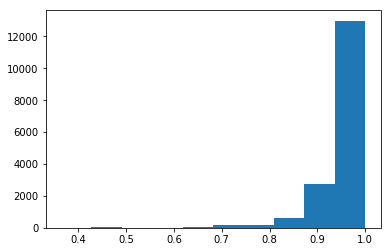

In [9]:
plt.hist(scores['Critics Score'])

We can now procede to normalize the scores so that they lie between 0 and 1.

In [10]:
# import numpy as np
# scaler = MinMaxScaler()
# new_scores = scaler.fit_transform(scores['Critics Score'].values.reshape((-1,1)))
# scores['Critics Score'] = new_scores.reshape(1,-1)[0]

## B. Validating the critical score

To validate the scores, we perform clustering after dimensionality reduction.

We first reduce the dimensionality of the data using PCA on the features we have (without the critical score).

In [11]:
reduced_data_2d = PCA(n_components=2).fit_transform(scores_cluster)

In [12]:
reduced_data_3d = PCA(n_components=3).fit_transform(scores_cluster)

After that, we perform clustering on the reduced data. This will show us whether establishments with similar scores cluster together.

In [13]:
kmeans_2d = KMeans(n_clusters=8).fit(reduced_data_2d)
y_kmeans_2d = kmeans_2d.predict(reduced_data_2d)

In [14]:
kmeans_3d = KMeans(n_clusters=8).fit(reduced_data_3d)
y_kmeans_3d = kmeans_3d.predict(reduced_data_3d)

In [15]:
labels = scores['Critics Score']

In [17]:

# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=50, cmap='viridis')
labels = scores['Critics Score']

fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.add_trace(go.Scatter(
    x=reduced_data_2d[:, 0],
    y=reduced_data_2d[:, 1],
    mode="markers",
    hovertext=labels,
    marker_color=y_kmeans_3d,
))

fig.update_layout(title_text="PCA plot with K-Means clustering (2D)")
fig.show()

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [18]:
import plotly
plotly.offline.plot(fig, filename='test.html')



'test.html'

In [19]:
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=50, cmap='viridis')
labels = scores['Critics Score']

fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.add_trace(go.Scatter3d(
    x=reduced_data_3d[:, 0],
    y=reduced_data_3d[:, 1],
    z=reduced_data_3d[:, 2],
    mode="markers",
    hovertext=labels,
    marker_color=y_kmeans_3d,
))

fig.update_layout(title_text="PCA plot with K-Means clustering (3D)")
fig.show()
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

We can see that there is a general trend in the data. The critical score gets lower as we go to the rght side of the plot whereas the really high critical scores are concentrated in the left side of the plot. Moreover, the lower scores are clustered in a group on the right and the high scores construct many clusters on the left.

We can hence see that the score we compute does in fact reflect the features that reflect the violations commited by the facilities.

# II. The user score

The user scored is computed in the FeatureForSafetyScore.ipynb notebook from the Yelp user rating. It is the one we will use as the user score.

In [21]:
scores.to_pickle('FINAL_SCORES.pickle')

In [22]:
scores

DBA Name  \
0                                  'LUNA EMPANADA SHOP'   
1                                10 PIN  BOWLING LOUNGE   
2                                      11 DEGREES NORTH   
3                                             14 PARISH   
4                                             1914 CLUB   
...                                                 ...   
16783  morrison authentic southern cooking and pizzeria   
16784                                       mr.daniel's   
16785                        ropa restaurant & wine bar   
16786                               subway restaurant 1   
16787                             tien giang restaurant   

                      Address   Community Area Facility Type   Latitude  \
0      6011 W IRVING PARK RD      Portage Park    Restaurant  41.952934   
1             330 N STATE ST              Loop    Restaurant  41.888361   
2          824 W BELMONT AVE         Lake View    Restaurant  41.940077   
3        2333 S MICHIGAN AVE   Near South Side    Restaurant  41.850118   
4          1060 W ADDISON ST         Lake View    Restaurant  41.947317   
...                       ...              ...           ...        ...   
16783     8131 S ASHLAND AVE    Auburn Gresham    Restaurant  41.745778   
16784     5645 W BELMONT AVE    Belmont Cragin    Restaurant  41.938443   
16785      1146 W PRATT BLVD       Rogers Park    Restaurant  42.005657   
16786    3348 W lawrence AVE       Albany Park    Restaurant  41.968514   
16787        4925 N Broadway            Uptown    Restaurant  41.972214   

       Longitude  Violation per Inspection  Critical Violation per Inspection  \
0     -87.777228                  0.000000                           0.000000   
1     -87.628180                  0.105556                           0.017857   
2     -87.650295                  0.107407                           0.011905   
3     -87.623589                  0.032099                           0.007937   
4     -87.656418                  0.053333                           0.000000   
...          ...                       ...                                ...   
16783 -87.663176                  0.000000                           0.000000   
16784 -87.768318                  0.000000                           0.000000   
16785 -87.660379                  0.333333                           0.285714   
16786 -87.712885                  0.014815                           0.000000   
16787 -87.659609                  0.061111                           0.053571   

       Moderate Violation per Inspection  \
0                               0.000000   
1                               0.050000   
2                               0.022222   
3                               0.000000   
4                               0.013333   
...                                  ...   
16783                           0.000000   
16784                           0.000000   
16785                           0.133333   
16786                           0.000000   
16787                           0.000000   

       Non-Critical Violation per Inspection  Critical Violations Ratio  \
0                                   0.000000                   0.000000   
1                                   0.234375                   0.052632   
2                                   0.270833                   0.034483   
3                                   0.083333                   0.076923   
4                                   0.137500                   0.000000   
...                                      ...                        ...   
16783                               0.000000                   0.000000   
16784                               0.000000                   0.000000   
16785                               0.562500                   0.266667   
16786                               0.041667                   0.000000   
16787                               0.125000                   0.272727   

       Yes Ratio of VomitDiarrheal